# Dimentionality reduction

In [1]:
import sys
from rdkit.Chem import rdFingerprintGenerator
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from rdkit import Chem
import pandas as pd
import numpy as np
import warnings
sys.path.append("../")
from tcad.cluster.butina import ButinaClustering
warnings.filterwarnings('ignore')

RDKIT_FINGERPRINT_GENERATOR = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
FINGERPRINT_LENGTH = 2048

## Prepare data

In [2]:
datapath = "../data/androgen_data.csv"

data = pd.read_csv(datapath)
smiles = list(data["canonical_smiles"])
chembl_ids = list(data['molecule_chembl_id'])

fingerprints = [RDKIT_FINGERPRINT_GENERATOR.GetFingerprint(Chem.MolFromSmiles(smile)) for smile in smiles]
fingerprints_array = np.zeros((len(fingerprints), FINGERPRINT_LENGTH))

for idx, fingerprint in enumerate(fingerprints):
    fingerprints_array[idx] = np.array(fingerprint)

In [3]:
def evaluate_components(fingerprints, max_components):
    variancies = []
    components = []
    
    for n_components in range(2, max_components):
        pca = PCA(n_components=n_components)
        _ = pca.fit_transform(fingerprints)
        varience = np.sum(pca.explained_variance_ratio_)
        variancies.append(varience*100)
        components.append(n_components)
    
    return components, variancies

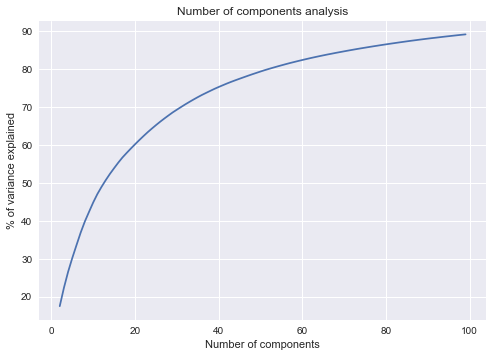

In [4]:
components, variencies = evaluate_components(fingerprints_array, 100)

plt.title("Number of components analysis")
plt.plot(components, variencies)
plt.xlabel("Number of components")
plt.ylabel("% of variance explained")
plt.show()

In [5]:
m_rank = np.linalg.matrix_rank(fingerprints_array)

print(f"Matrix dims (MxN): {fingerprints_array.shape}")
print(f"Matrix rank: {m_rank}")

pca = PCA(m_rank)
_ = pca.fit_transform(fingerprints_array)
variance = np.sum(pca.explained_variance_ratio_)

print(f"Varience explained by {m_rank} features is: {np.round(variance*100, 3)}%")

Matrix dims (MxN): (1521, 2048)
Matrix rank: 1060
Varience explained by 1060 features is: 100.0%


In [6]:
pca = PCA(n_components=100)
reduced_data = pca.fit_transform(fingerprints_array)

embedded_data = TSNE(n_components=2).fit_transform(reduced_data)

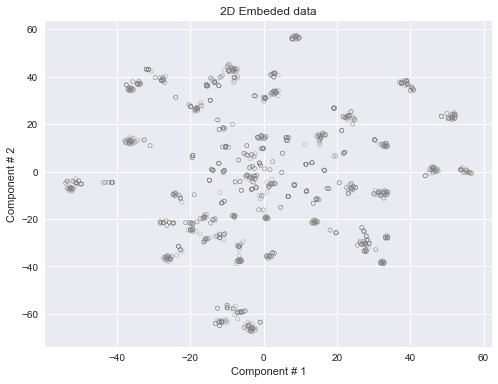

In [7]:
_, ax = plt.subplots(figsize=(8,6))
ax.scatter(x=embedded_data[:,0], y=embedded_data[:,1], s=17, facecolors='none', edgecolors='gray')
ax.set_title("2D Embeded data")
ax.set_xlabel("Component # 1")
ax.set_ylabel("Component # 2")
plt.show()

In [8]:
butina_cluster = ButinaClustering(smiles, chembl_ids, 0.2)
butina_cluster.cluster()
cluster0 = butina_cluster.clusters[3]
cluster1 = butina_cluster.clusters[4]
cluster2 = butina_cluster.clusters[5]

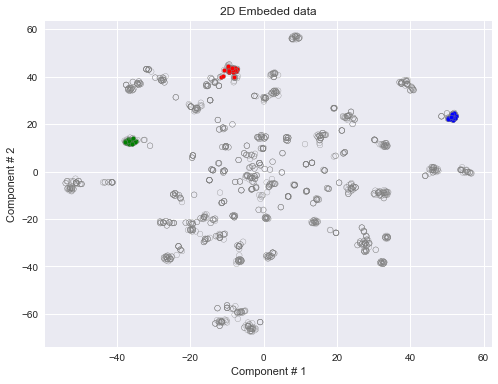

In [9]:
_, ax = plt.subplots(figsize=(8,6))
ax.scatter(x=embedded_data[:,0], y=embedded_data[:,1], s=32, facecolors='none', edgecolors='gray')

for molecule_id in cluster0:
    ax.scatter(x=embedded_data[:,0][molecule_id], y=embedded_data[:,1][molecule_id], s=17, facecolors='red', edgecolors='gray')

for molecule_id in cluster1:
    ax.scatter(x=embedded_data[:,0][molecule_id], y=embedded_data[:,1][molecule_id], s=17, facecolors='green', edgecolors='gray')

for molecule_id in cluster2:
    ax.scatter(x=embedded_data[:,0][molecule_id], y=embedded_data[:,1][molecule_id], s=17, facecolors='blue', edgecolors='gray')

ax.set_title("2D Embeded data")
ax.set_xlabel("Component # 1")
ax.set_ylabel("Component # 2")

plt.show()